# Hands in Gothic Literature
## Eunice Chan
August 16, 2019

Introduction to Computational Literary Analysis

UC-Berkeley, Summer 2019

Instructor: Jonathan Reeve

## Introduction
In modern society, the objectification of women is heavily associated with the disparity of power between men and women. Ever rampant in artistic works is the male gaze with which women are depicted from a masculine, heterosexual perspective as sexual objects. The gaze tend to focus on women not as a whole individual, but as a collection of parts. Gothic novels tend to be dramatic and suspenseful tales of women in distress threatened by a powerful masculine figure. Although the focus of gothic novels tend to be women, and many writers in this genre are women, the power dynamics within the novels tend to cast women in helpless roles. Because of this, I am interested in examining how power dynamics affect the language used to portray men and women. I will do this by first focusing on the segmentation of the human body, and how the treatment of men and women with regards to their physical portrayal differs. Next, I will narrow the scope and focus specifically on the difference in the treatment of hands split by gender.

## Import

In [1]:
import requests
import json
from string import punctuation
import pickle
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
stop_words = set(stopwords.words('english'))

## Corpus
I will examine the physical portrayal of men and women in gothic novels with a combination of distant and close reading.

In [3]:
# I chose to collect my corpus programmatically rather than hand-picking novels
# because if I were to manually choose the novels to include, it would not include 
# as great of a breadth of gothic novels, and it would be a very laborious process 
# if I wanted to look at a very large corpus.

# I chose to use corpus-db in particular because I want to look at a large number 
# of gothic novels and to be certain that the collection consists of only gothic 
# novels. With corpus-db, I am able to assume that the collection consists of only 
# gothic novels.

# URL to all the books on Project Gutenburg that are tagged Gothic fiction.
url = "http://corpus-db.org/api/subject/Gothic%20fiction%20(Literary%20genre)"
# Get the data from the url.
gothic = requests.get(url=url)
# Load it into a json format.
data = json.loads(gothic.text)

## Preprocessing

In [4]:
# I decided to filter my corpus such that I am only examining gothic novels 
# originally written in English so that I won't have to also consider the 
# influence that different cultures or translations would have on my findings.
# Add all the English book ids to a list.
ids = [book["id"] for book in data if "'en'" in book["languages"]]
# Add all the book titles to a list.
titles = [book["title"] for book in data if "'en'" in book["languages"] and book["id"] in ids]

In [5]:
# Do not look at ids with empty text.
empty_text_ids = []
for n in ids:
    # Get the full text of the book associated with the current id.
    text = requests.get("http://corpus-db.org/api/id/"+n+"/fulltext")
    # Load the text as a string.
    text = json.loads(text.text)
    # If the text is empty, add the id to the list.
    if not text:
        empty_text_ids += [n]
empty_text_ids

['696.0', '2706.0', '5083.0', '38460.0', '42401.0']

In [6]:
# Remove the ids of books with no text from the list of ids.
ids = set(ids) - set(empty_text_ids)
len(ids)

43

In [7]:
author_name = [book["author"] for book in data if book["id"] in ids]
author_wiki = [book["wikipedia"] for book in data if book["id"] in ids]
author_yob = [book["authoryearofbirth"] for book in data if book["id"] in ids]
author_yod = [book["authoryearofdeath"] for book in data if book["id"] in ids]

In [8]:
json.loads(data[4]["creator"].replace("'", "\""))["author"]["wikipedia"]

'http://en.wikipedia.org/wiki/Matthew_Gregory_Lewis'

In [9]:
# Create an empty list to put all the text of the books in.
book_texts = []
# Add all the text of each book in the Gothic fiction category to the list.
for n in ids:
    # Get the full text of the book associated with the current id.
    text = requests.get("http://corpus-db.org/api/id/"+n+"/fulltext")
    # Load the text as a string.
    text = json.loads(text.text)
    # Add it to the list.
    book_texts += [text[0]["text"]]

In [10]:
# Add all the book titles to a list.
titles = [book["title"] for book in data if "'en'" in book["languages"] and book["id"] in ids]
# There are 40 unique books in my corpus.
len(set(titles))

40

In [11]:
# Collect the texts in a dictionary.
book_dict = {title:{"Text":text,
                    "Author Name": name,
                    "Wikipedia": wiki,
                    "Author Year of Birth": yob,
                    "Author Year of Death": yod}
             for title, text, name, wiki, yob, yod
             in zip(titles, book_texts, author_name, author_wiki, author_yob, author_yod)}
len(book_dict.keys())

40

In [12]:
# Redefine titles to list only the unique texts in my corpus.
titles = list(book_dict.keys())
# Same with the list of book_texts
book_texts = [book_dict[title]["Text"] for title in titles]
# Create a version of book_texts that is word tokenized.
book_texts_words = [nltk.word_tokenize(book) for book in book_texts]

In [13]:
# Create one long string of all the text in the corpus.
all_lower_gothic = " ".join(book_texts).lower()
# Tokenize the corpus by words.
all_lower_gothic_tokens = nltk.word_tokenize(all_lower_gothic)
# Clean tokens of punctuation.
gothic_no_punc = [w for w in all_lower_gothic_tokens if w not in punctuation]
# Clean tokens of punctuation and stopwords.
gothic_no_stop = [w for w in gothic_no_punc if w not in stop_words]
# Convert it to an nltk text object.
one_gothic_text = nltk.text.Text(all_lower_gothic_tokens)

## Count Body Parts
First, I will examine the counts of body parts in gothic novels to get a general idea of what parts of the body are focused upon the most.

In [14]:
# The hypernym of all words I am interested in (body parts).
body = wn.synsets("body_part")[0]

In [15]:
# Add the body parts mentioned in the book to the book's entry in book_dict.
for title, book_tokens in zip(titles, book_texts_words):
    print(title, end = "")
    # Tag the book with the parts of speech.
    book_pos = nltk.pos_tag(book_tokens)
    # Only take noun words.
    nouns = [w[0] for w in book_pos if "NN" in w[1]]
    body_parts =[]
    # Look in the list of nouns.
    for word in nouns:
        word_sn = wn.synsets(word , "n")
        if word_sn:
            body_hyper = body.lowest_common_hypernyms(word_sn[0])
            # If "body_part" is a hypernym, then add the word to the list of body parts for the book.
            if body_hyper and body_hyper[0] == body:
                body_parts += [word.lower()]
    print("...DONE!")
    book_dict[title]["Body Parts"] = body_parts
print("FINISHED!")

Frankenstein; Or, The Modern Prometheus...DONE!
Northanger Abbey...DONE!
Dracula...DONE!
The Woman in White...DONE!
The Monk: A Romance...DONE!
Wieland; Or, The Transformation: An American Tale...DONE!
The Fall of the House of Usher...DONE!
The Lair of the White Worm...DONE!
The History of Caliph Vathek...DONE!
The Man...DONE!
The Mysteries of Udolpho...DONE!
The Old English Baron: a Gothic Story...DONE!
The Vampyre; a Tale...DONE!
The Adventures of Ferdinand Count Fathom — Volume 01...DONE!
The Adventures of Ferdinand Count Fathom — Volume 02...DONE!
The Adventures of Ferdinand Count Fathom — Complete...DONE!
A Sicilian Romance...DONE!
Anna St. Ives...DONE!
Nightmare Abbey...DONE!
Dracula's Guest...DONE!
The Evil Guest...DONE!
Barford Abbey, A Novel: In A Series Of Letters...DONE!
The Bell in the Fog and Other Stories...DONE!
Varney the Vampire; Or, the Feast of Blood...DONE!
Uncle Silas: A Tale of Bartram-Haugh...DONE!
Fantazius Mallare: A Mysterious Oath...DONE!
Alonzo and Melissa; 

In [16]:
# Collect all body parts mentioned across all of the books in my corpus into one list.
all_body_parts = []
for book in book_dict:
    all_body_parts += book_dict[book]["Body Parts"]

In [17]:
body_parts = list(set(all_body_parts))
# 231 distinct body parts mentioned!
len(body_parts)

233

In [18]:
# The top 3 most common body parts far exceed the other body parts!
# The body parts only mentioned once or twice are mostly sexual organs.
body_count = Counter(all_body_parts).most_common()
body_count[:10]

[('hand', 3405),
 ('face', 2593),
 ('head', 2003),
 ('eye', 876),
 ('lips', 866),
 ('feet', 729),
 ('arm', 687),
 ('foot', 413),
 ('ears', 384),
 ('mouth', 345)]

In [19]:
print("HAND COUNT:", all_lower_gothic_tokens.count("hand"))
print("HANDS COUNT:", all_lower_gothic_tokens.count("hands"))

HAND COUNT: 3405
HANDS COUNT: 1728


A straightforward count of body parts shows that “hand” tends to be the greatest focus. I looked up the counts of “hands” versus “hand” with the assumption the terms are mostly used to refer to the body parts. I discovered the count for singular “hand” is 3372 while “hands” is 1706. From the word counts for other body parts, plural and singular forms of body parts tend to occur with roughly the same frequency. For example, “cheeks” appear 290 times while “cheek” appears 273. 

"Hand" has various idiomatic meanings such as "on the other hand," which is a frequent four-gram in the gothic novel, and various usages that isn't related to body parts, such as "hand in marriage." However, from the concordance, the majority of the usage tends to be referring to body parts. The count for “hand” is almost double the count for “hands.” Assuming that this difference is great enough to offset the usage of “hand(s)” in contexts other than body parts, I hypothesize that the plural means something different in the context of gothic novels.

Because “hand(s)" has a raw count that far exceed the counts of other body parts, I will focus on hands and their function in the context of gothic novels.

## Individual Versus Parts
I hypothesize that due to the male gaze and the imbalanced power dynamic between genders in gothic novels that female characters would be objectified more than the male characters. This is complicated for me to operationalized on a large scale because characters could be referred directly by their names, and I would need to categorize each name by their gender. My workaround is to just look at pronouns because I assume that it would roughly show whether female characters or male characters are more often described in terms of their body parts.

In [20]:
# "Him" refers to the male object of a verb or preposition but the equivalent "her"
# refers to that AND acts as a determiner. An example of this is: "her hand." As a 
# result, because I would overcount "her" as an object of a verb, I decided not to 
# count instances of "him" and "her."

individual_male = "he"
individual_female = "she"
male_part = "his"
female_part = "her"

### Count of References to Individuals by Gender

In [21]:
male_individual_count = all_lower_gothic_tokens.count(individual_male)
male_individual_count

51652

In [22]:
female_individual_count = all_lower_gothic_tokens.count(individual_female)
female_individual_count

30626

### Count of References to Parts by Gender

In [23]:
male_body_parts = pickle.load(open("male_body_parts.pickle", "rb"))
female_body_parts = pickle.load(open("female_body_parts.pickle", "rb"))

In [24]:
female_body_count = sum(female_body_parts.values())
female_body_count

2946

In [25]:
male_body_count = sum(male_body_parts.values())
male_body_count

4282

In [26]:
part_to_whole_DF = pd.DataFrame(data={"Part": [male_body_count, female_body_count],
                                      "Whole": [male_individual_count, female_individual_count]},
                                index=["Male", "Female"])
part_to_whole_DF["Total"] = part_to_whole_DF.Part + part_to_whole_DF.Whole
part_to_whole_DF["Proportion Objectified"] = part_to_whole_DF.Part/part_to_whole_DF.Total

part_to_whole_DF.head()

,Part,Whole,Total,Proportion Objectified
Male,4282,51652,55934,0.076555
Female,2946,30626,33572,0.087752


According to the table, the difference between male and female objectification is about 1%. As this is a count of the proportion of references being body parts versus the person as a whole, and because I am just looking at pronoun usage, it’s such a small difference I cannot tell if women are more objectified than men. However, the conclusion I can draw from this is that the proportion of male and female references to the body versus whole is not extremely different.

## Body Parts by Gender

In [27]:
low = 0.6
high = 0.95
colors = [(np.random.uniform(low=low, high=high),
                  np.random.uniform(low=low, high=high),
                  np.random.uniform(low=low, high=high)) for i in range(len(all_body_parts))]
color_coded_parts = {part:color for part, color in zip(all_body_parts, colors)}

In [28]:
def n_grams_word(text, word, n):
    return [w for w in nltk.ngrams(text, n) if word in w]

In [29]:
def top_n_body_parts_mentioned(n, body_parts, group_type):
    top_n = pd.Series(body_parts).sort_values(ascending=False)[:n]
    top_n_colors = [color_coded_parts[part] for part in top_n.index]
    pie = top_n.plot.pie(figsize=(5, 5), colors=top_n_colors, autopct="%1.0f%%")
    pie.set_title("Top {} Mentioned Body Parts of {}".format(n, group_type))
    pie.set_ylabel('');
    plt.show()
    return

In [30]:
hand = [gram for gram in nltk.ngrams(one_gothic_text, 2) if gram[1] == "hand"]

In [31]:
hand_count = Counter(n_grams_word(gothic_no_punc, "hand", 2))
len(hand_count)

808

In [32]:
hand_count.most_common(10)

[(('his', 'hand'), 731),
 (('her', 'hand'), 518),
 (('hand', 'and'), 484),
 (('my', 'hand'), 415),
 (('the', 'hand'), 287),
 (('hand', 'to'), 210),
 (('hand', 'of'), 158),
 (('hand', 'in'), 156),
 (('at', 'hand'), 141),
 (("'s", 'hand'), 136)]

The bigrams of “hand" reflects its usage. “My hand” is much more prevalent than “the hand.” This means the narrators focus more on his or her own hand, possibly to carry out their will, than someone else’s. This marks hand as playing an active role in the gothic novel.

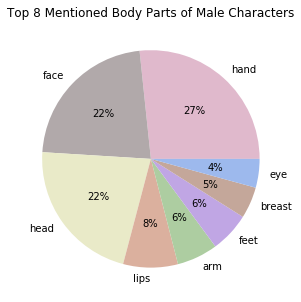

In [33]:
top_n_body_parts_mentioned(8, male_body_parts, "Male Characters")

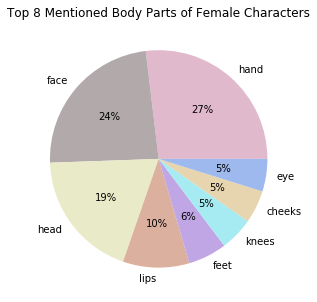

In [34]:
top_n_body_parts_mentioned(8, female_body_parts, "Female Characters")

Female characters' faces and lips are mentioned slightly more than male characters, and their head is mentioned slightly less. Other common references to female characters tend to be knees and cheeks, while gothic novels tend to focus on the arm and breast of male characters. This reflects a difference in where the attention is placed for male and female characters. For male characters, gothic novels tend to focus broadly on the upper body while for female characters, the novels tend to focus on bits and pieces. The focus is not just on her face, but on the lips and cheeks. The reader's gaze is not just directed towards the general body, but to small, specific components. By being more detailed about the locations, the reader is encouraged to think about how that area looks like on the character, and thus the emphasis is placed on the character's physical appearance rather than the character's gestures.

This implies that although attention may be drawn towards the same areas on the male and female body, the kind of attention being drawn differs for each gender. When referencing the male body, it is shown to express the male's action and will. Meanwhile, when referencing the female body, attention is drawn unduly towards specific regions, drawing attention to her physical appearance in addition to whatever was the purpose of describing the female's body.

## Contexts of Hands
From the other common words used to describe male and female, the difference in treatment of characters by gender began to make itself apparent. However, this is an idea that was formed from a distant reading. To strengthen the observations made, context is needed. For the top body part, the hands, I will examine the context it is used in to explore the way the body parts are treated differently between the male and female genders.

In [35]:
def n_gram_context(n_gram, text):
    text_sent = nltk.sent_tokenize(text)
    sentences = []
    for sent in text_sent:
        i = sent.find(n_gram)
        if i != -1:
            if not sent[i+len(n_gram)].isalpha():
                sentences += [sent]
    return sentences

In [36]:
def lst_in_sent(lst, sent):
    sent = nltk.word_tokenize(sent)
    for w in lst:
        if w in sent:
            return True
    return False

In [37]:
def sent_by_gender(sents, gender):
    if gender == "m":
        part = male_part
        individual = individual_male
    if gender == "f":
        part = female_part
        individual = individual_female
    return [s for s in sents if lst_in_sent([part, individual], s)]

In [38]:
# Look at the way "hand" is used.
one_gothic_text.concordance("hand")

Displaying 25 of 3405 matches:
s , who occupied stools on the right hand , and were leaning their backs again
. ' at the same time he advanced his hand towards the gauze : the lady raised 
l and beautiful in the extreme ; her hand and arm were formed with the most pe
arge grains of amber , fell from his hand , and dropped among the surrounding 
ite so delicate in me to accept your hand at first sight . ' 'accept my hand ?
r hand at first sight . ' 'accept my hand ? as i hope to live and breathe ... 
s , she extended a lean and wrinkled hand ; which her supposed admirer kissed 
e no objection to my offering her my hand . i should be a villain could i thin
heek ; with a graceful motion of her hand she beckoned to him to advance . he 
 by the concussion . lorenzo put his hand to his sword . 'how now , segnor ? '
a look of suspicion he drew back his hand , which the other was preparing to t
 conde ? and when i presented him my hand , did you observe the air of passion
 don christoval had k

In [39]:
Counter(n_grams_word(gothic_no_stop, "hand", 2)).most_common(10)

[(("'s", 'hand'), 139),
 (('took', 'hand'), 121),
 (('held', 'hand'), 98),
 (('hand', '``'), 98),
 (('one', 'hand'), 95),
 (('hand', 'upon'), 93),
 (('right', 'hand'), 82),
 (('laid', 'hand'), 79),
 (('put', 'hand'), 71),
 (('hand', '--'), 61)]

Looking at the most common bigrams with the word "hand," it tends to be related to someone's hand being upon something or someone's hand being taken. The former places the hand in an active role while the latter places it in a passive role.

In [40]:
hand_sents = n_gram_context("'s hand", all_lower_gothic)
len(hand_sents)

138

In [41]:
his_hand = sent_by_gender(hand_sents, "m")
len(his_hand)

66

In [42]:
his_hand[30:40]

["there were tears in his eyes as he wrung the squire's hand;\nhis voice thrilled with feeling as he said:\n\n'your many goodnesses to my father's son, sir, will, i hope, be justified\nby his love and loyalty.",
 "then,\nfeeling her father's hand on her head she turned and leaped into his\narms, where he held her close.",
 "mr. stonehouse came to him and said as he grasped harold's hand so hard\nthat his fingers ached:\n\n'i cannot thank you as i would.",
 "as he turned away pearl, who had now been holding close to\nher mother's hand, sprang to him holding up her arms.",
 "then instinctively grasping the old\nman's hand he said:\n\n'you overwhelm me.",
 'when ferdinand\'s hand clasped hers, she laid the other upon it, gazing\nin his eyes with a warm and affectionate light beaming in her own, and\nsaying with a thoughtful, if not absent air, as if the question she\nput was as much to her own heart as to him,--"you love me, dear\nferdinand,--is it not so?',
 '"he shows him favour,\nit is

I created a list of sentences with the bigram "'s hand." I roughly split it into sentences describing a male (any sentence with a male pronoun) and sentences describe a female. From the list of sentences describing males, the function of the masculine hand in gothic novels tend to be expressing sincerity through the motions, such as grasping someone else's hands. It reflects a very active role, because the hand is reaching out of their own accord to communicate.

In [43]:
her_hand = sent_by_gender(hand_sents, "f")
len(her_hand)

50

In [44]:
her_hand[30:40]

["as he turned away pearl, who had now been holding close to\nher mother's hand, sprang to him holding up her arms.",
 "for a long time she lay still, holding with her\nright hand, which was not paralysed, the other's hand.",
 'when ferdinand\'s hand clasped hers, she laid the other upon it, gazing\nin his eyes with a warm and affectionate light beaming in her own, and\nsaying with a thoughtful, if not absent air, as if the question she\nput was as much to her own heart as to him,--"you love me, dear\nferdinand,--is it not so?',
 'adelaide caught the lady\'s hand, and kissed it; and gently releasing\nherself from her husband\'s embrace, the countess of ehrenstein\napproached his brother, and said, in a low tone, "you are free, my\nlord; you had better, perhaps, retire, and for a time betake you to\nsome place of seclusion till my lord and husband has forgotten some of\nthe past events, or has time to think more gently of them."',
 'one glance at his wife, as she still clung to\nhis arm

## Actions of Hands

In [45]:
def n_words_around_tagged(n, text, tag):
    size = len(text)
    hand_contexts = []
    # Get the n words around the word "hand"
    for i, w in enumerate(text):
        if w == "hand" or w == "hands":
            start = i-n
            end = i+n+1
            if i < n:
                start = 0
            elif i > size - n:
                end = size
            hand_contexts += text[start:i] + text[i+1:end]
    hand_actions = [w for w, t in nltk.pos_tag(hand_contexts) if tag in t]
    return hand_actions

In [46]:
hand_actions = n_words_around_tagged(5, gothic_no_stop, "VB")
len(hand_actions)

13985

In [47]:
actions_5 = Counter(hand_actions).most_common(10)
actions_5

[('said', 480),
 ('took', 321),
 ('held', 261),
 ('put', 167),
 ('came', 133),
 ('holding', 116),
 ('kissed', 114),
 ('made', 113),
 ('laid', 109),
 ('looked', 108)]

In [48]:
actions_1 = Counter(n_words_around_tagged(1, gothic_no_stop, "VB")).most_common(10)
actions_1

[('took', 176),
 ('held', 142),
 ('put', 80),
 ('clasped', 71),
 ('laid', 62),
 ('kissed', 60),
 ('said', 60),
 ('holding', 58),
 ('placed', 56),
 ('pressed', 54)]

The most common words immediately before and after the word "hand(s)" (excluding stopwords) is very interesting to me, because it shows what the hands do. Many of these terms are directed. For example, if a hand is "took," then someone is doing the taking and someone's hand is being taken. If a hand is kissed, someone must be doing the kissing and someone is being kissed.

These terms all have a source of the action and a receiver of the action, reflecting the unequal power dynamics in gothic novels.

In [49]:
actions_only_1 = [a for a, b in actions_1]
actions_only_5 = [a for a, b in actions_5]

In [50]:
# Words ranked in the top 10 most common only in the immediate vicinity of the words "hands."
# What contexts hands are immediately related to.
set(actions_only_1).difference(actions_only_5)

{'clasped', 'placed', 'pressed'}

In [51]:
# Words ranked in the top 10 most common only in the general vicinity of the words "hands."
# What contexts hands are generally related to.
set(actions_only_5).difference(actions_only_1)

{'came', 'looked', 'made'}

The words associated hands are mostly associated with, that is, the terms that are most common in the immediate and general vicinity of the words "hands" are: "said," "took," and "held." Even when looking at the words immediately before and after the hand (excluding stopwords), the top 10 words are mostly the same, showing that hands are closely associated to those terms. The association with "took" and "held" reflects the findings in the close reading that characters tend to get their hands taken or held by another character, or they tend to take or hold someone else's hands. From the close reading, I was able to determine this is an action done in part to communicate rapport and express trustworthiness.

The association of hands with "said" shows that the actions done by the hands tend to be shortly before, shortly after, or during dialogue. Given what I've seen of the usage of hands in the corpus, the function of hands are used to emphasize and supplement a character's communication. They act as the main form of nonverbal communication.

In [52]:
just_hand_sents = n_gram_context("hand", all_lower_gothic)

In [53]:
pronouns = {"he", "she", "him", "her", "his", "hers", "himself", "herself"}

In [54]:
stop_words_wo_pronouns = stop_words - pronouns

In [55]:
def n_grams_by_gender(text, gender, n):
    hand_actions = sent_by_gender(text, gender)
    hand_no_punc = "".join([w for w in " ".join(hand_actions) if w not in punctuation])
    hand_no_stop = [w for w in nltk.word_tokenize(hand_no_punc) if w not in stop_words_wo_pronouns]
    return hand_no_stop, n_grams_word(hand_no_stop, "hand", n)

In [56]:
male_hand_no_stop, n_gram_male_3 = n_grams_by_gender(just_hand_sents, "m", 3)
Counter(n_gram_male_3).most_common(10)

[(('his', 'hand', 'he'), 75),
 (('his', 'hand', 'his'), 60),
 (('laid', 'his', 'hand'), 45),
 (('held', 'his', 'hand'), 44),
 (('his', 'hand', 'upon'), 39),
 (('put', 'his', 'hand'), 33),
 (('his', 'right', 'hand'), 31),
 (('hand', 'upon', 'his'), 29),
 (('her', 'hand', 'his'), 28),
 (('took', 'her', 'hand'), 25)]

In [57]:
_, n_gram_male_4 = n_grams_by_gender(just_hand_sents, "m", 4)
Counter(n_gram_male_4).most_common(10)

[(('he', 'laid', 'his', 'hand'), 22),
 (('he', 'held', 'his', 'hand'), 21),
 (('laid', 'his', 'hand', 'upon'), 18),
 (('his', 'hand', 'upon', 'his'), 16),
 (('he', 'took', 'her', 'hand'), 15),
 (('he', 'put', 'his', 'hand'), 13),
 (('put', 'his', 'hand', 'his'), 9),
 (('her', 'hand', 'upon', 'his'), 9),
 (('hand', 'upon', 'his', 'arm'), 9),
 (('he', 'waved', 'his', 'hand'), 8)]

Looking at the most common 3-grams and 4-grams for sentences involving a male character, I am able to see which gender is commonly at the source and recieving end of the actions. Common relationships are: "(he) laid his hand," "(he) held his hand," "(he) put his hand," "(he) took her hand," "(he) pressed (her) hand upon his lips," "(he put his/her?) hand upon his arm."

Although the reason why the 4-gram "he laid his hand" has the count of 23 while the 3-gram "laid is hand" has the count of 46 could be because there is the usage of a different gender ("she laid his hand"), if that was the case, we would likely see "she laid his hand," for example, in the common 4-grams, which isn't the case. More likely, the remainder of the "X laid his hand" have names instead of pronouns. The names are most likely masculine, given the fact "he laid his hand" is far more common than "she laid his hand."

I apply this reasoning to the rest of the common phrases. Interpreted this way, the list shows the unequal power dynamics. It is commonly a male figure initiating actions with his hands, and a female figure receiving the action (having her hands taken, and having her hands pressed against his lips). In the context of the novels, these tend to be common actions between members of high society, as the kissing of the hand is a common form of greeting. This list thus highlights the power disparity between men and women built into and normalized by the social norms, even among those of equal class. The women tend to be placed in passive, receiving roles while the men exercise their will.

In [58]:
female_hand_no_stop, n_gram_female_3 = n_grams_by_gender(just_hand_sents, "f", 3)
Counter(n_gram_female_3).most_common(10)

[(('took', 'her', 'hand'), 45),
 (('her', 'hand', 'she'), 41),
 (('held', 'her', 'hand'), 31),
 (('her', 'hand', 'his'), 30),
 (('her', 'hand', 'her'), 28),
 (('taking', 'her', 'hand'), 24),
 (('her', 'hand', 'upon'), 24),
 (('laid', 'her', 'hand'), 24),
 (('her', 'hand', 'he'), 17),
 (('put', 'her', 'hand'), 14)]

In [59]:
_, n_gram_female_4 = n_grams_by_gender(just_hand_sents, "f", 4)
Counter(n_gram_female_4).most_common(10)

[(('he', 'took', 'her', 'hand'), 15),
 (('she', 'held', 'her', 'hand'), 14),
 (('she', 'put', 'her', 'hand'), 11),
 (('laid', 'her', 'hand', 'upon'), 10),
 (('her', 'hand', 'upon', 'his'), 9),
 (('pressed', 'her', 'hand', 'his'), 7),
 (('hand', 'upon', 'his', 'arm'), 7),
 (('she', 'laid', 'her', 'hand'), 7),
 (('her', 'hand', 'his', 'lips'), 6),
 (('she', 'took', 'his', 'hand'), 6)]

A commonality between these female sentences and the male sentences from before is that the women also "held her hand," "put her hand," "laid her hand upon," and "she took his hand." Referencing the same custom as before where men kiss the hand of the women, the phrase "(he) pressed (her) hand upon his lips" is mirrored by the 4-gram "(her) hand pressed his lips."

Interestingly, the n-grams show that women are not entirely helpless and is able to exercise her will much like the men: they also hold, put, and lay their hands, as well as taking other people's hands. To complicate this statement, however, the order of these actions differ between the two genders. For women, taking someone else's hand is much less common: "he took her hand" comes in at 15 while "she took his hand" only appears 6 times in the corpus--less than half the times when the gender is switched. This reflects the power dynamics in male-female relationships similarly to the way the kissing does. One person is in the role of power and subjugation: the one who takes the hand, and one person is in the role of the subjugated: the one whose hand is taken.

In [60]:
Counter(n_words_around_tagged(1, male_hand_no_stop, "JJ")).most_common(5)

[('right', 12), ('strong', 11), ('pressed', 7), ('young', 7), ('close', 6)]

In [61]:
Counter(n_words_around_tagged(1, female_hand_no_stop, "JJ")).most_common(5)

[('right', 9), ('little', 8), ('pressed', 6), ('cold', 6), ('old', 5)]

The way male and female hands are described differs. Most strikingly, masculine hands are described as "strong" and "young," implying power and a youthful vigor. This contrasts with the way feminine hands are described, "little" and "cold," which evokes a sense of weak helplessness and mortal fraility. Tying back to the pie charts from before where I had noticed feminine characters are described with more specific body parts, the observation that more emphasis is placed on the physical appearances of the feminine characters is supported by the adjectives surrounding the hands of the characers. Masculine characters tend to have more general adjectives which shows that the description of their hands is just a means to describe their personality while feminine characters have more concrete, physical adjectives which shows that the description of their hands is to make their appearances more concrete in the reader's mind which supports the hypothesis that female characters in gothic novels have excessive attention placed on their appearances--especially in comparison to the male characters.

## Conclusion
I examined the way the body is portrayed for each gender. I began by examining the proportion of body segmentation, which was not entirely clear because of the difficulties in computationalizing. I then moved on to examining the specific body segmentation by gender and discovered the differences in the segmentations of men and women: the novels tend to focus on very specific body parts when discussing the feminine body. Meanwhile, when discussing the masculine body, the body parts referenced tend to be more general and broad.

Next, I decided to look more closely at this difference in the context of hands, as the hands were the most referenced body part. Through a combination of close reading of sentences that include hands, and distant reading by looking at the prevalent n-grams, I saw that even something as small as the hand is subjugated to social norms that reflect the unequal power dynamic between genders. By looking at how the hands were described, I was able to tie the hands back to my broader observation that female characters tend to be described by their physical appearances for the sake of emphasizing their physical appearances, while male characters tend to have their physical form described to reflect their will. This shows that although body parts are mentioned almost in equal proportions for male and female characters, the emphasis on the physical appearances of female characters objectifies them, making them objects for the reader's imaginative viewing pleasure rather than characters. This general approach to female characters, as well as the passitivity of the feminine hand reflects the unequal power dynamics between genders in the corpus.